In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import CubicHermiteSpline
import cmocean
import gsw
import xgcm
import veros.core.density.nonlinear_eq2 as neq2
import veros.core.density as dens
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib import colors
import diagnostic_function as diagf
from matplotlib.lines import Line2D


Importing core modules
 Using computational backend numpy on cpu
 Runtime settings are now locked



In [3]:
def axis_depth_long_two_fields(axis, field, field_color_name, field_lines_name, span, norm='Normalize', levels = 31, labeled_levels = [-5000], cmap = "cmo.balance", neg_pos = False):
    vmin, vmax = span
    linestyle_neg = 'solid'
    if neg_pos :
        linestyle_neg = 'dashed'
        
    if norm=='Normalize':
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    elif norm=='TwoSlopeNorm':
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    contour = field_color_name.plot.contourf(ax=axis, levels=levels, norm=norm, cmap=cmap, add_colorbar=False)
    
    field_color_name.where(field_color_name > 0).plot.contour(ax=axis, norm=norm, levels=levels, colors='k', linestyles='solid', alpha=0.15)
    field_color_name.where(field_color_name <= 0).plot.contour(ax=axis, norm=norm, levels=levels, colors='k', linestyles=linestyle_neg, alpha=0.1)
    
    labeled_contour_lines = field_lines_name.plot.contour(ax=axis, levels=labeled_levels, colors='k', linestyles=linestyle_neg, alpha=0.5)
    axis.clabel(labeled_contour_lines, levels=labeled_levels, fmt="%.2f", inline=True, fontsize=8, colors="black")
    axis.set_title(field)
    #ax.set_xlim(-70,0)

    return contour

$$\psi_{bolus} = \int_{x=0}^{x=L} B1_{gm} \cos(u) dx $$
$$\psi_{euler} = \int_{x=0}^{x=L} \int_{z=0/H ?}^z v \cos(u) \delta_{V} dx dz_t $$
$$ \implies B1_{gm} = \int_{z=0/H ?}^z v_{bolus} \delta_{V} dz_t  $$
$$ \implies B2_{gm} = \int_{z=0/H ?}^z u_{bolus} \delta_{V} dz_t  ? $$

u, zonal, v, meridional
B1, zonal, B2 meridional ??


$$\begin{align}
\vec{\nabla} \cdot \vec{u} = 0  \implies w_{bolus} &= - \int_{z=0/H ?}^z \partial_x u_{bolus} + \partial_y v_{bolus} dz\\
                   &= - (\partial_x B2_{gm} +\partial_y B1_{gm})

\end{align}$$



In [4]:
ds_ovr_NoW = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/NoW/nw2_dino.0000.overturning.nc", decode_times=False)
ds_ovr_NoW_SO = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/NoW_SO/nw2_dino.0000.overturning.nc", decode_times=False)
ds_ovr_REF = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/Dino/nw2_dino.0000.overturning.nc", decode_times=False)
ds_ovr_2W = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/2W/nw2_dino.0000.overturning.nc", decode_times=False)
ds_ovr_2W_SO = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/2W_SO/nw2_dino.0000.overturning.nc", decode_times=False)
ds_ovr_Clim_bis = xr.open_mfdataset("/home/x_titmo/work/runs_output/NW2_clim/End_run/Clim_bis/nw2_dino.0000.overturning.nc", decode_times=False)

ds_snap = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001_backup/Dino/nw2_dino.0000.snapshot.nc", decode_times=False)

datasets_ovr = {"NoW": ds_ovr_NoW, "NoW_SO": ds_ovr_NoW_SO, "REF": ds_ovr_REF, "2W": ds_ovr_2W, "2W_SO": ds_ovr_2W_SO, "Clim_bis" : ds_ovr_Clim_bis}
keys_to_plot = ["NoW", "NoW_SO", "REF", "2W_SO", "2W", "Clim_bis"]

In [5]:
ds_avg_NoW = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/NoW/nw2_dino.0000.averages.nc", decode_times=False)
ds_avg_NoW_SO = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/NoW_SO/nw2_dino.0000.averages.nc", decode_times=False)
ds_avg_REF = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/Dino/nw2_dino.0000.averages.nc", decode_times=False)
ds_avg_2W = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/2W/nw2_dino.0000.averages.nc", decode_times=False)
ds_avg_2W_SO = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001/2W_SO/nw2_dino.0000.averages.nc", decode_times=False)
ds_avg_Clim_bis = xr.open_mfdataset("/home/x_titmo/work/runs_output/NW2_clim/End_run/Clim_bis/nw2_dino.0000.averages.nc", decode_times=False)

datasets_avg = {"NoW": ds_avg_NoW, "NoW_SO": ds_avg_NoW_SO, "REF": ds_avg_REF, "2W": ds_avg_2W, "2W_SO": ds_avg_2W_SO, "Clim_bis" : ds_avg_Clim_bis }

In [11]:
ds_snap_NoW = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001_backup/NoW/nw2_dino.0000.snapshot.nc", decode_times=False)
ds_snap_NoW_SO = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001_backup/NoW_SO/nw2_dino.0000.snapshot.nc", decode_times=False)
ds_snap_REF = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001_backup/Dino/nw2_dino.0000.snapshot.nc", decode_times=False)
ds_snap_2W = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001_backup/2W/nw2_dino.0000.snapshot.nc", decode_times=False)
ds_snap_2W_SO = xr.open_mfdataset("/home/x_titmo/work/runs_output/NeverWorld2/y_1001_backup/2W_SO/nw2_dino.0000.snapshot.nc", decode_times=False)
ds_snap_Clim_bis = xr.open_mfdataset("/home/x_titmo/work/runs_output/NW2_clim/End_run/Clim_bis/nw2_dino.0000.snapshot.nc", decode_times=False)

datasets_snap = {"NoW": ds_snap_NoW, "NoW_SO": ds_snap_NoW_SO, "REF": ds_snap_REF, "2W": ds_snap_2W, "2W_SO": ds_snap_2W_SO, "Clim_bis" : ds_snap_Clim_bis}
keys_to_plot = ["NoW", "NoW_SO", "REF", "2W_SO", "Clim_bis","2W"]

In [12]:
tw = {
    "NoW_SO": 0,
    "REF": 1,
    "2W_SO": 2,
    "NoW": 0,
    "2W": 2,
}

In [13]:
for key in keys_to_plot :
    datasets_ovr[key] = datasets_ovr[key].assign_coords(years=("Time", (datasets_ovr[key].Time / 365).data))
    datasets_avg[key] = datasets_avg[key].assign_coords(years=("Time", (datasets_avg[key].Time / 365).data))
    datasets_snap[key] = datasets_snap[key].assign_coords(years=("Time", (datasets_snap[key].Time / 365).data))

land_mask = (ds_snap.zt.to_numpy()[:,np.newaxis, np.newaxis] <= -ds_snap.bathymetry.to_numpy()[np.newaxis,...]) | (ds_snap.salt.isel(Time=0).drop_vars("Time") == 0.0)

weight_xyz_t = (1-land_mask) * ds_snap.area_t * ds_snap.dzt
weight_xyz_t = weight_xyz_t.fillna(0) / weight_xyz_t.sum()
weights_xy_t = weight_xyz_t / weight_xyz_t.sum('xt').sum('yt')
weights_z_t = weight_xyz_t.mean(dim=('xt','yt'))

land_mask_W = xr.DataArray(land_mask.values, dims=('zw', 'yt', 'xt'), coords={'zw': ds_snap.zw, 'yt': ds_snap.yt, 'xt': ds_snap.xt})

weight_xyz_w = (1-land_mask_W) * ds_snap.area_t * ds_snap.dzw
weight_xyz_w = weight_xyz_w.fillna(0) / weight_xyz_w.sum()
weights_xy_w = weight_xyz_w / weight_xyz_w.sum('xt').sum('yt')
weights_z_w = weight_xyz_w.mean(dim=('xt','yt'))

weight_surf = ds_snap.area_t.fillna(0)
weight_surf =weight_surf/ weight_surf.sum('xt').sum('yt')

In [20]:
dict_moc_sigma, dict_bolus_sigma, dict_rmoc_sigma = {}, {}, {}
dict_H_thin ={}
dict_H_thin_sigma ={}

for key in keys_to_plot :
    ytp = 1001
    if key=="LNS":
        ytp=1200
    salinity = datasets_avg[key]["salt"].sel(Time=ytp * 365, method="nearest")
    temperature = datasets_avg[key]["temp"].sel(Time=ytp * 365, method="nearest")

    sigma2 = 24. + neq2.nonlin2_eq_of_state_rho(salinity, temperature, p =2000)
    zonal_sigma2 = sigma2.weighted(weight_xyz_t).mean(dim='xt')
    zonal_sigma2_interp = zonal_sigma2.interp(zt=ds_snap.zw, method="linear").interp(yt=ds_snap.yu, method="linear")


    bolus = -(datasets_ovr[key].bolus_depth * 1e-6).isel(Time=-1)
    moc = -(datasets_ovr[key].vsf_depth * 1e-6).isel(Time=-1)

    ds_moc = moc.to_dataset(name='moc')
    ds_bolus = bolus.to_dataset(name='bolus')

    coords = {'Z': {'center': 'zw'}}
    grid_moc = xgcm.Grid(ds_moc, coords=coords, periodic=False)
    grid_bolus = xgcm.Grid(ds_bolus, coords=coords, periodic=False)

    sigma_target = np.linspace(28.,35, 100)

    moc_sigma = grid_moc.transform(moc, 'Z', sigma_target, target_data=zonal_sigma2_interp, method='linear')
    bolus_sigma = grid_bolus.transform(bolus, 'Z', sigma_target, target_data=zonal_sigma2_interp, method='linear')
    rmoc_sigma = moc_sigma + bolus_sigma

    dict_moc_sigma[key] = moc_sigma
    dict_bolus_sigma[key] = bolus_sigma
    dict_rmoc_sigma[key] = rmoc_sigma
    
    #Pycnocline H=4000m, zv=-2000m (env)
    z_bottom_mask = ds_snap.zt.where(ds_snap.zt > -4000).min()
    mask_4000 = (ds_snap.zt >= z_bottom_mask) & (((1-land_mask)*ds_snap.zt).min(dim='zt')<= z_bottom_mask)
    zmean_4000 = temperature.zt.where(mask_4000).weighted(weight_xyz_t).mean(dim=("xt","yt","zt"))
    salinity_pyc = salinity.where(mask_4000)
    temperature_pyc = temperature.where(mask_4000)
    meridional_pic_fab_4000, zonavg_depth_anomaly_approx_4000, zonavg_mean_N2_approx_4000, H_plus_4000, H_thin_4000 = diagf.pycnocline_fab(salinity_pyc, temperature_pyc, -2*zmean_4000, ds_snap.zt, weight_surf, weight_xyz_t, land_mask)
    dict_H_thin[key] = H_thin_4000
    
    sigma2_at_H  = zonal_sigma2.interp(zt=H_thin_4000)
    dict_H_thin_sigma[key] = sigma2_at_H

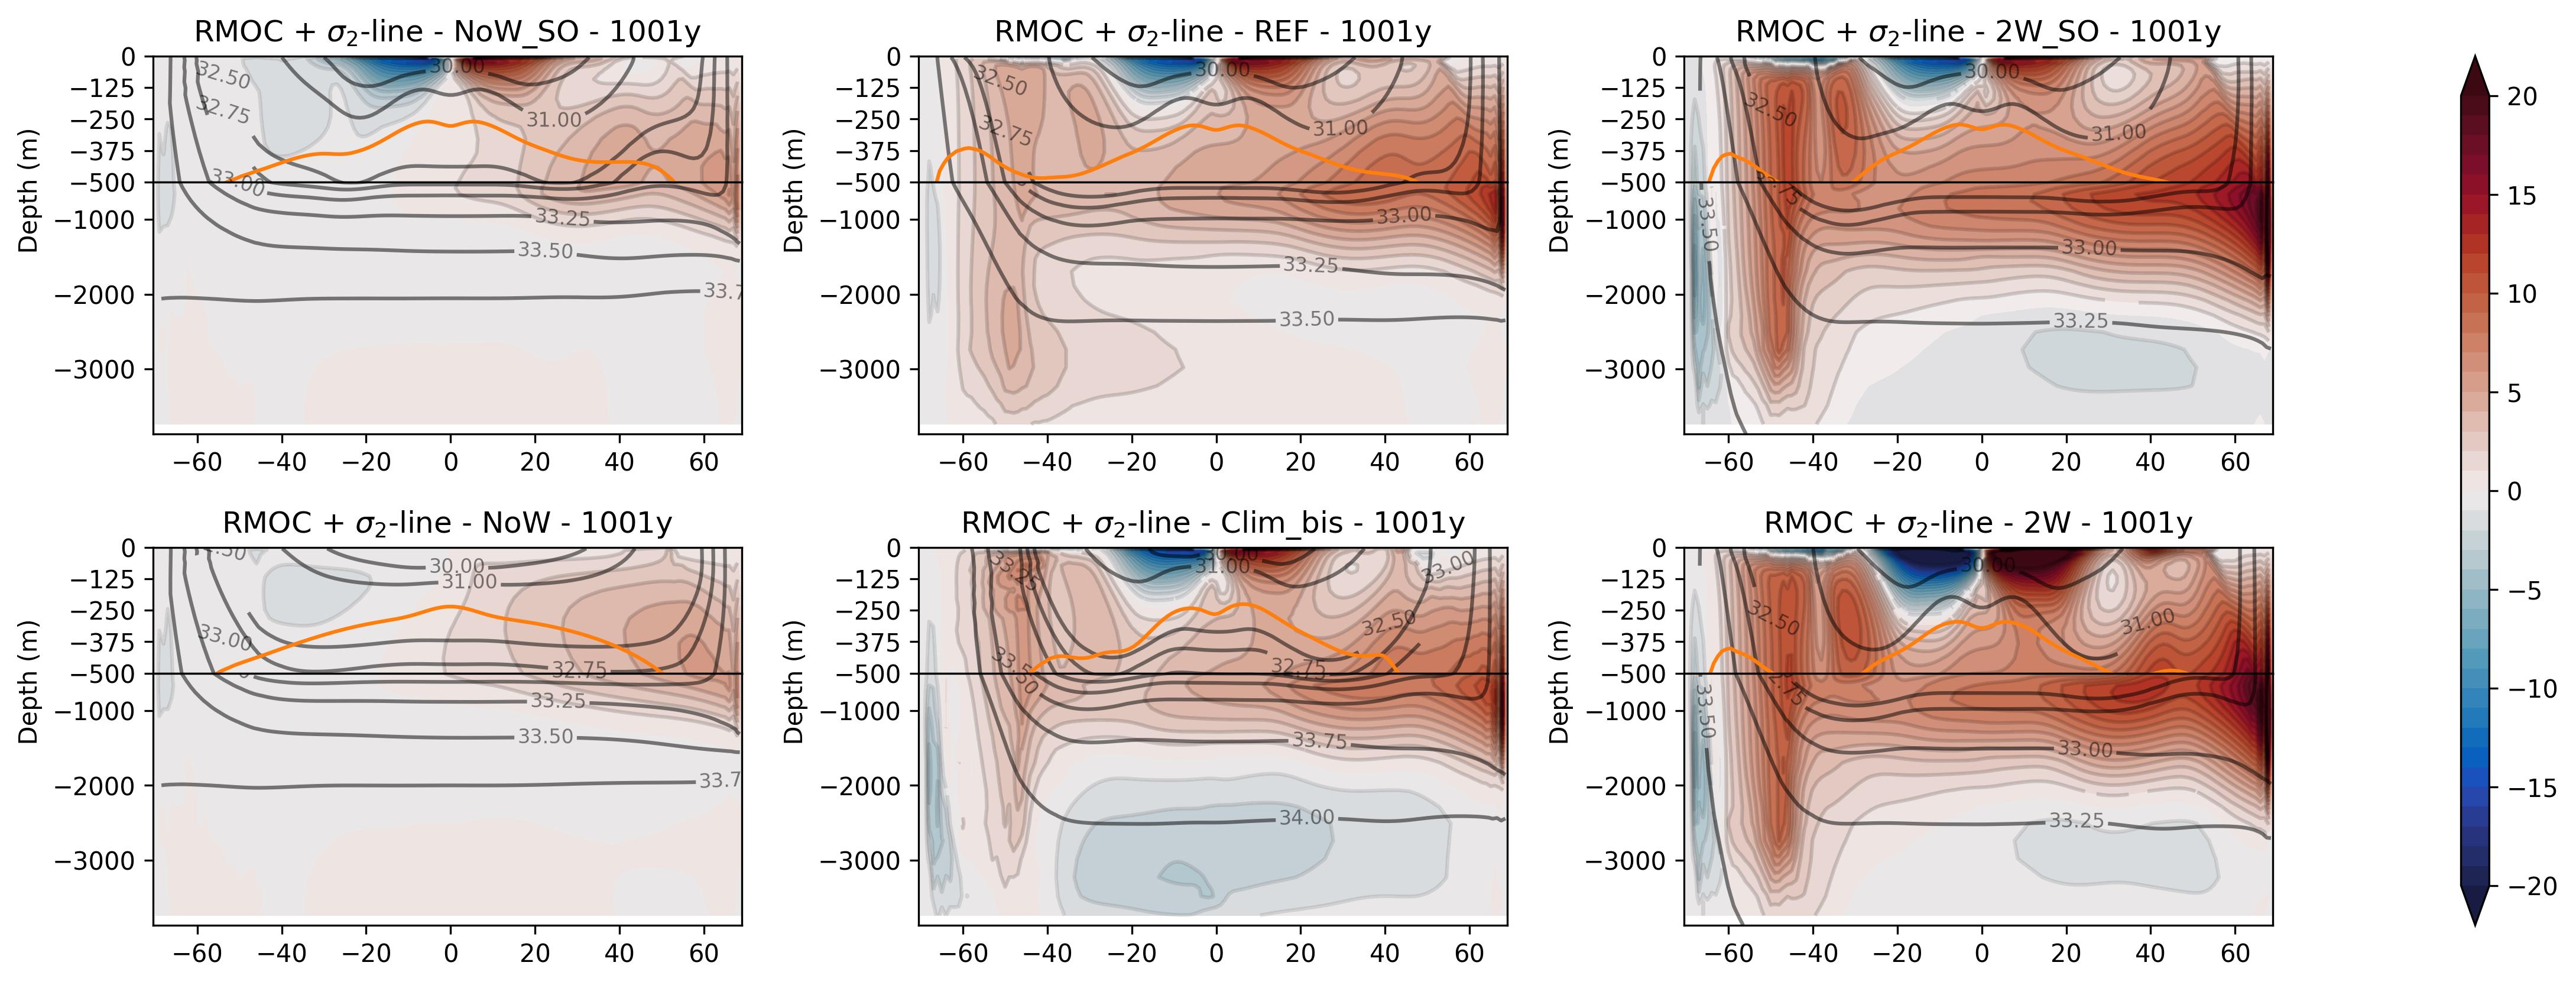

In [21]:
fig = plt.figure(figsize=(17,9), dpi=300)
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[3, 0.04], height_ratios=[7,2], wspace=0.175)
gs_figs = gs[0,0].subgridspec(2, 3, hspace=0.3, wspace=0.3)
for idx, key in enumerate(["NoW_SO", "REF", "2W_SO", "NoW", "Clim_bis", "2W"]):
    year=" - 1001y"
    if key=="LNS":
        year=" - 1200y"
        continue
    row, col = divmod(idx, 3)
    gs_row_col = gs_figs[row,col].subgridspec(2, 1, height_ratios = [1,2], hspace=0)
    ax_up = fig.add_subplot(gs_row_col[0])
    ax_down = fig.add_subplot(gs_row_col[1])
    
    sigma2 = 24. + neq2.nonlin2_eq_of_state_rho(datasets_avg[key].salt.isel(Time=-1), datasets_avg[key].temp.isel(Time=-1), p =2000)
    zonal_sigma2 = sigma2.weighted(weight_xyz_t).mean(dim='xt')
    rmoc = -(datasets_ovr[key].vsf_depth * 1e-6 + datasets_ovr[key].bolus_depth * 1e-6).isel(Time=-1)
    labeled_lines_sig2 = [30., 31., 32.5, 32.75, 33., 33.25, 33.5, 33.75, 34., 34.5, 35.]
    contour_up = axis_depth_long_two_fields(ax_up, "RMOC", rmoc, zonal_sigma2, span = (-20,20), levels = 41, labeled_levels = labeled_lines_sig2)
    contour_down = axis_depth_long_two_fields(ax_down, "RMOC", rmoc, zonal_sigma2, span = (-20,20), levels = 41, labeled_levels = labeled_lines_sig2)
    H_thin_contour = dict_H_thin[key].sel(yt=slice(None, None)).plot(ax= ax_up, color='tab:orange', linewidth=1.5, label=r'$H_{thin}$')

    ax_up.set_title( r"RMOC + $\sigma_2$-line - " + key + year )
    ax_up.set_ylim(-500,0)
    ax_down.set_ylim(None,-500)
    ax_up.set_yticks([0,-125, -250, -375, -500])
    ax_down.set_xlabel("")
    ax_up.set_ylabel("")
    ax_down.set_ylabel("                              Depth (m)")
    ax_down.set_title('')

cax = fig.add_subplot(gs[0,1])  # Span the first two rows for temperature colorbar
fig.colorbar(contour_up, cax=cax, orientation='vertical')


plt.tight_layout()
plt.show()

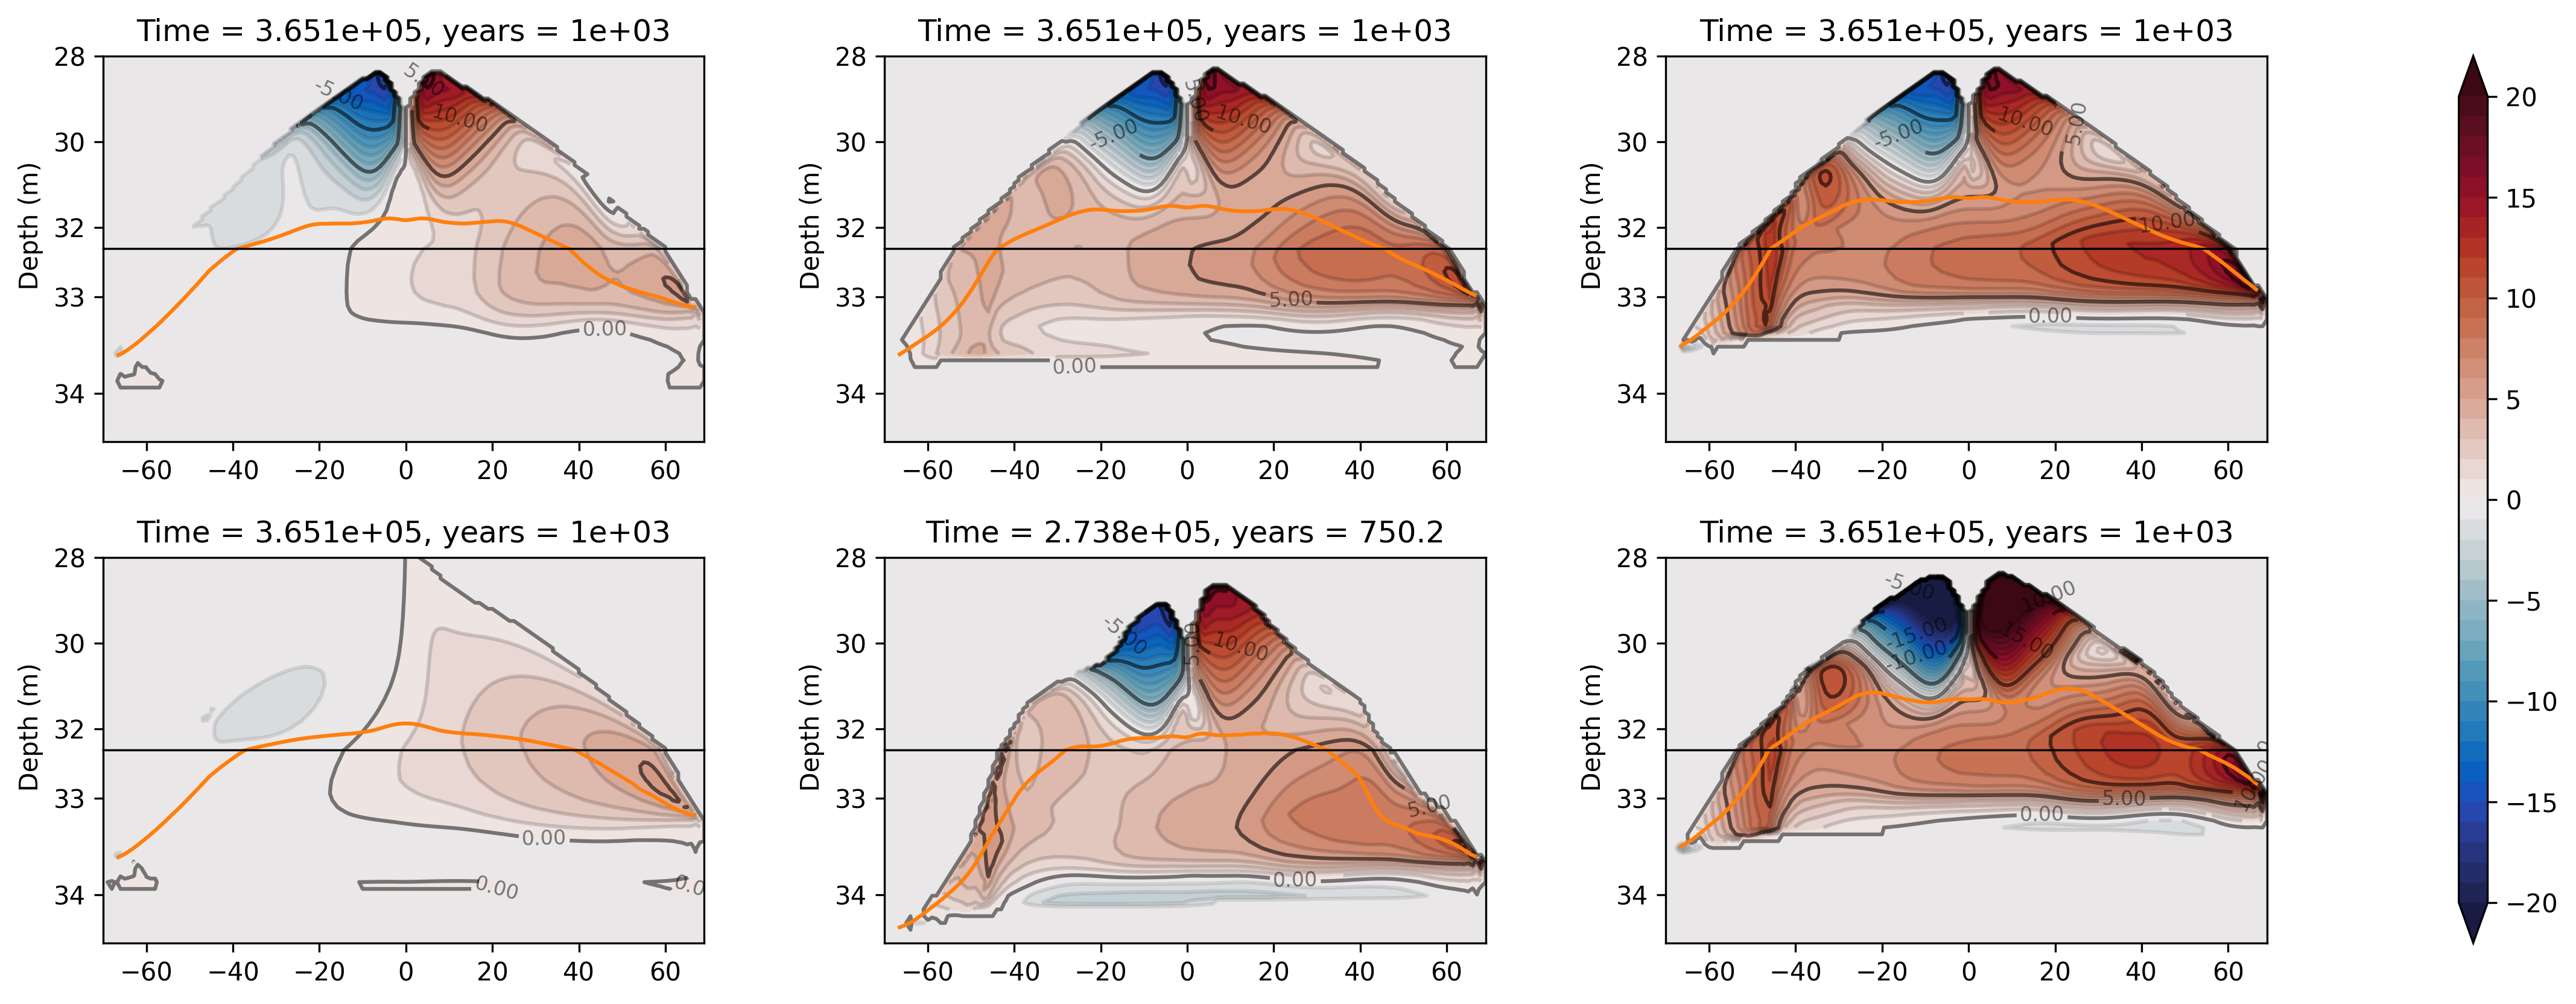

In [22]:
fig = plt.figure(figsize=(17,9), dpi=300)
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[3, 0.04], height_ratios=[7,2], wspace=0.175)
gs_figs = gs[0,0].subgridspec(2, 3, hspace=0.3, wspace=0.3)
for idx, key in enumerate(["NoW_SO", "REF", "2W_SO", "NoW", "Clim_bis", "2W"]):
    year=" - 1001y"
    if key=="LNS":
        year=" - 1200y"
        continue
    row, col = divmod(idx, 3)
    gs_row_col = gs_figs[row,col].subgridspec(2, 1, height_ratios = [1,1], hspace=0)
    ax_up = fig.add_subplot(gs_row_col[0])
    ax_down = fig.add_subplot(gs_row_col[1])
    
    
    labeled_lines_sig2 = [-15., -10., -5., 0., 5., 10., 15.]
    contour_up = axis_depth_long_two_fields(ax_up, "RMOC", dict_rmoc_sigma[key].T.fillna(0), dict_rmoc_sigma[key].T.fillna(0), span = (-20,20), levels = 41, labeled_levels = labeled_lines_sig2)
    contour_down = axis_depth_long_two_fields(ax_down, "RMOC", dict_rmoc_sigma[key].T.fillna(0), dict_rmoc_sigma[key].T.fillna(0), span = (-20,20), levels = 41, labeled_levels = labeled_lines_sig2)
    ax_up.set_title( r"RMOC" + key + year )
    
    H_sig = dict_H_thin_sigma[key]
    H_sig.plot(ax=ax_up, color ='tab:orange')
    H_sig.plot(ax=ax_down, color ='tab:orange')

    ax_up.set_ylim(32.5, 28)
    ax_down.set_ylim(34.5,32.5)


    ax_down.set_xlabel("")
    ax_up.set_ylabel("")
    ax_down.set_ylabel("                              Depth (m)")
    ax_down.set_title('')

cax = fig.add_subplot(gs[0,1])  # Span the first two rows for temperature colorbar
fig.colorbar(contour_up, cax=cax, orientation='vertical')


plt.tight_layout()
plt.show()


In [17]:
def plot_axis_i(fig, gs, axis, field, vm=15, title_i ='', sig_lims=(28, 32.5,34)):
    gsi = gs[axis].subgridspec(2, 2, height_ratios=[1, 2], width_ratios = [1,2], wspace=0, hspace=0)
    ax_NW = fig.add_subplot(gsi[0,0])
    ax_NE = fig.add_subplot(gsi[0,1])
    ax_SW = fig.add_subplot(gsi[1,0])
    ax_SE = fig.add_subplot(gsi[1,1])
    cont = field.plot.contourf(ax=ax_NW, y='zt', cmap='cmo.balance', levels=61, vmin=-vm, vmax=vm, add_colorbar=False)
    field.plot.contourf(ax=ax_NE, y='zt', cmap='cmo.balance', levels=61,  vmin=-vm, vmax=vm, add_colorbar=False)
    field.plot.contourf(ax=ax_SE, y='zt', cmap='cmo.balance', levels=61,  vmin=-vm, vmax=vm, add_colorbar=False)
    field.plot.contourf(ax=ax_SW, y='zt', cmap='cmo.balance', levels=61,  vmin=-vm, vmax=vm, add_colorbar=False)
    
    field.plot.contour(ax=ax_NW, y='zt', levels=10, vmin=-vm, vmax=vm, colors='k', linestyles='solid', alpha=0.5)
    field.plot.contour(ax=ax_NE, y='zt', levels=10,  vmin=-vm, vmax=vm, colors='k', linestyles='solid', alpha=0.5)
    field.plot.contour(ax=ax_SE, y='zt', levels=10, vmin=-vm, vmax=vm, colors='k', linestyles='solid', alpha=0.5)
    field.plot.contour(ax=ax_SW, y='zt', levels=10,  vmin=-vm, vmax=vm, colors='k', linestyles='solid', alpha=0.5)
    
    sl_l, sl_c, sl_r = sig_lims
    ax_NW.grid(),            ax_NE.grid(),            ax_SW.grid(),              ax_SE.grid()
    ax_NW.set_title(''),     ax_NE.set_title(''),     ax_SW.set_title(''),       ax_SE.set_title('')
    ax_NW.set_xlim(sl_l,sl_c), ax_NE.set_xlim(sl_c,sl_r), ax_SW.set_xlim(sl_l,sl_c),   ax_SE.set_xlim(sl_c,sl_r)
    ax_NW.set_ylim(-500,0),  ax_NE.set_ylim(-500,0),  ax_SW.set_ylim(None,-500), ax_SE.set_ylim(None,-500)
    ax_NW.set_ylabel(''),    ax_NE.set_ylabel(''),                               ax_SE.set_ylabel('')

    ax_NW.set_xticklabels([]),    ax_NE.set_xticklabels([])
    ax_NE.set_yticklabels([]),    ax_SE.set_yticklabels([])

    ax_NE.set_yticks([0,-125, -250, -375, -500]), ax_NW.set_yticks([0,-125, -250, -375, -500])
    ax_SE.set_xlabel('')
    ax_NW.set_title('                          ' + title_i)
    return cont



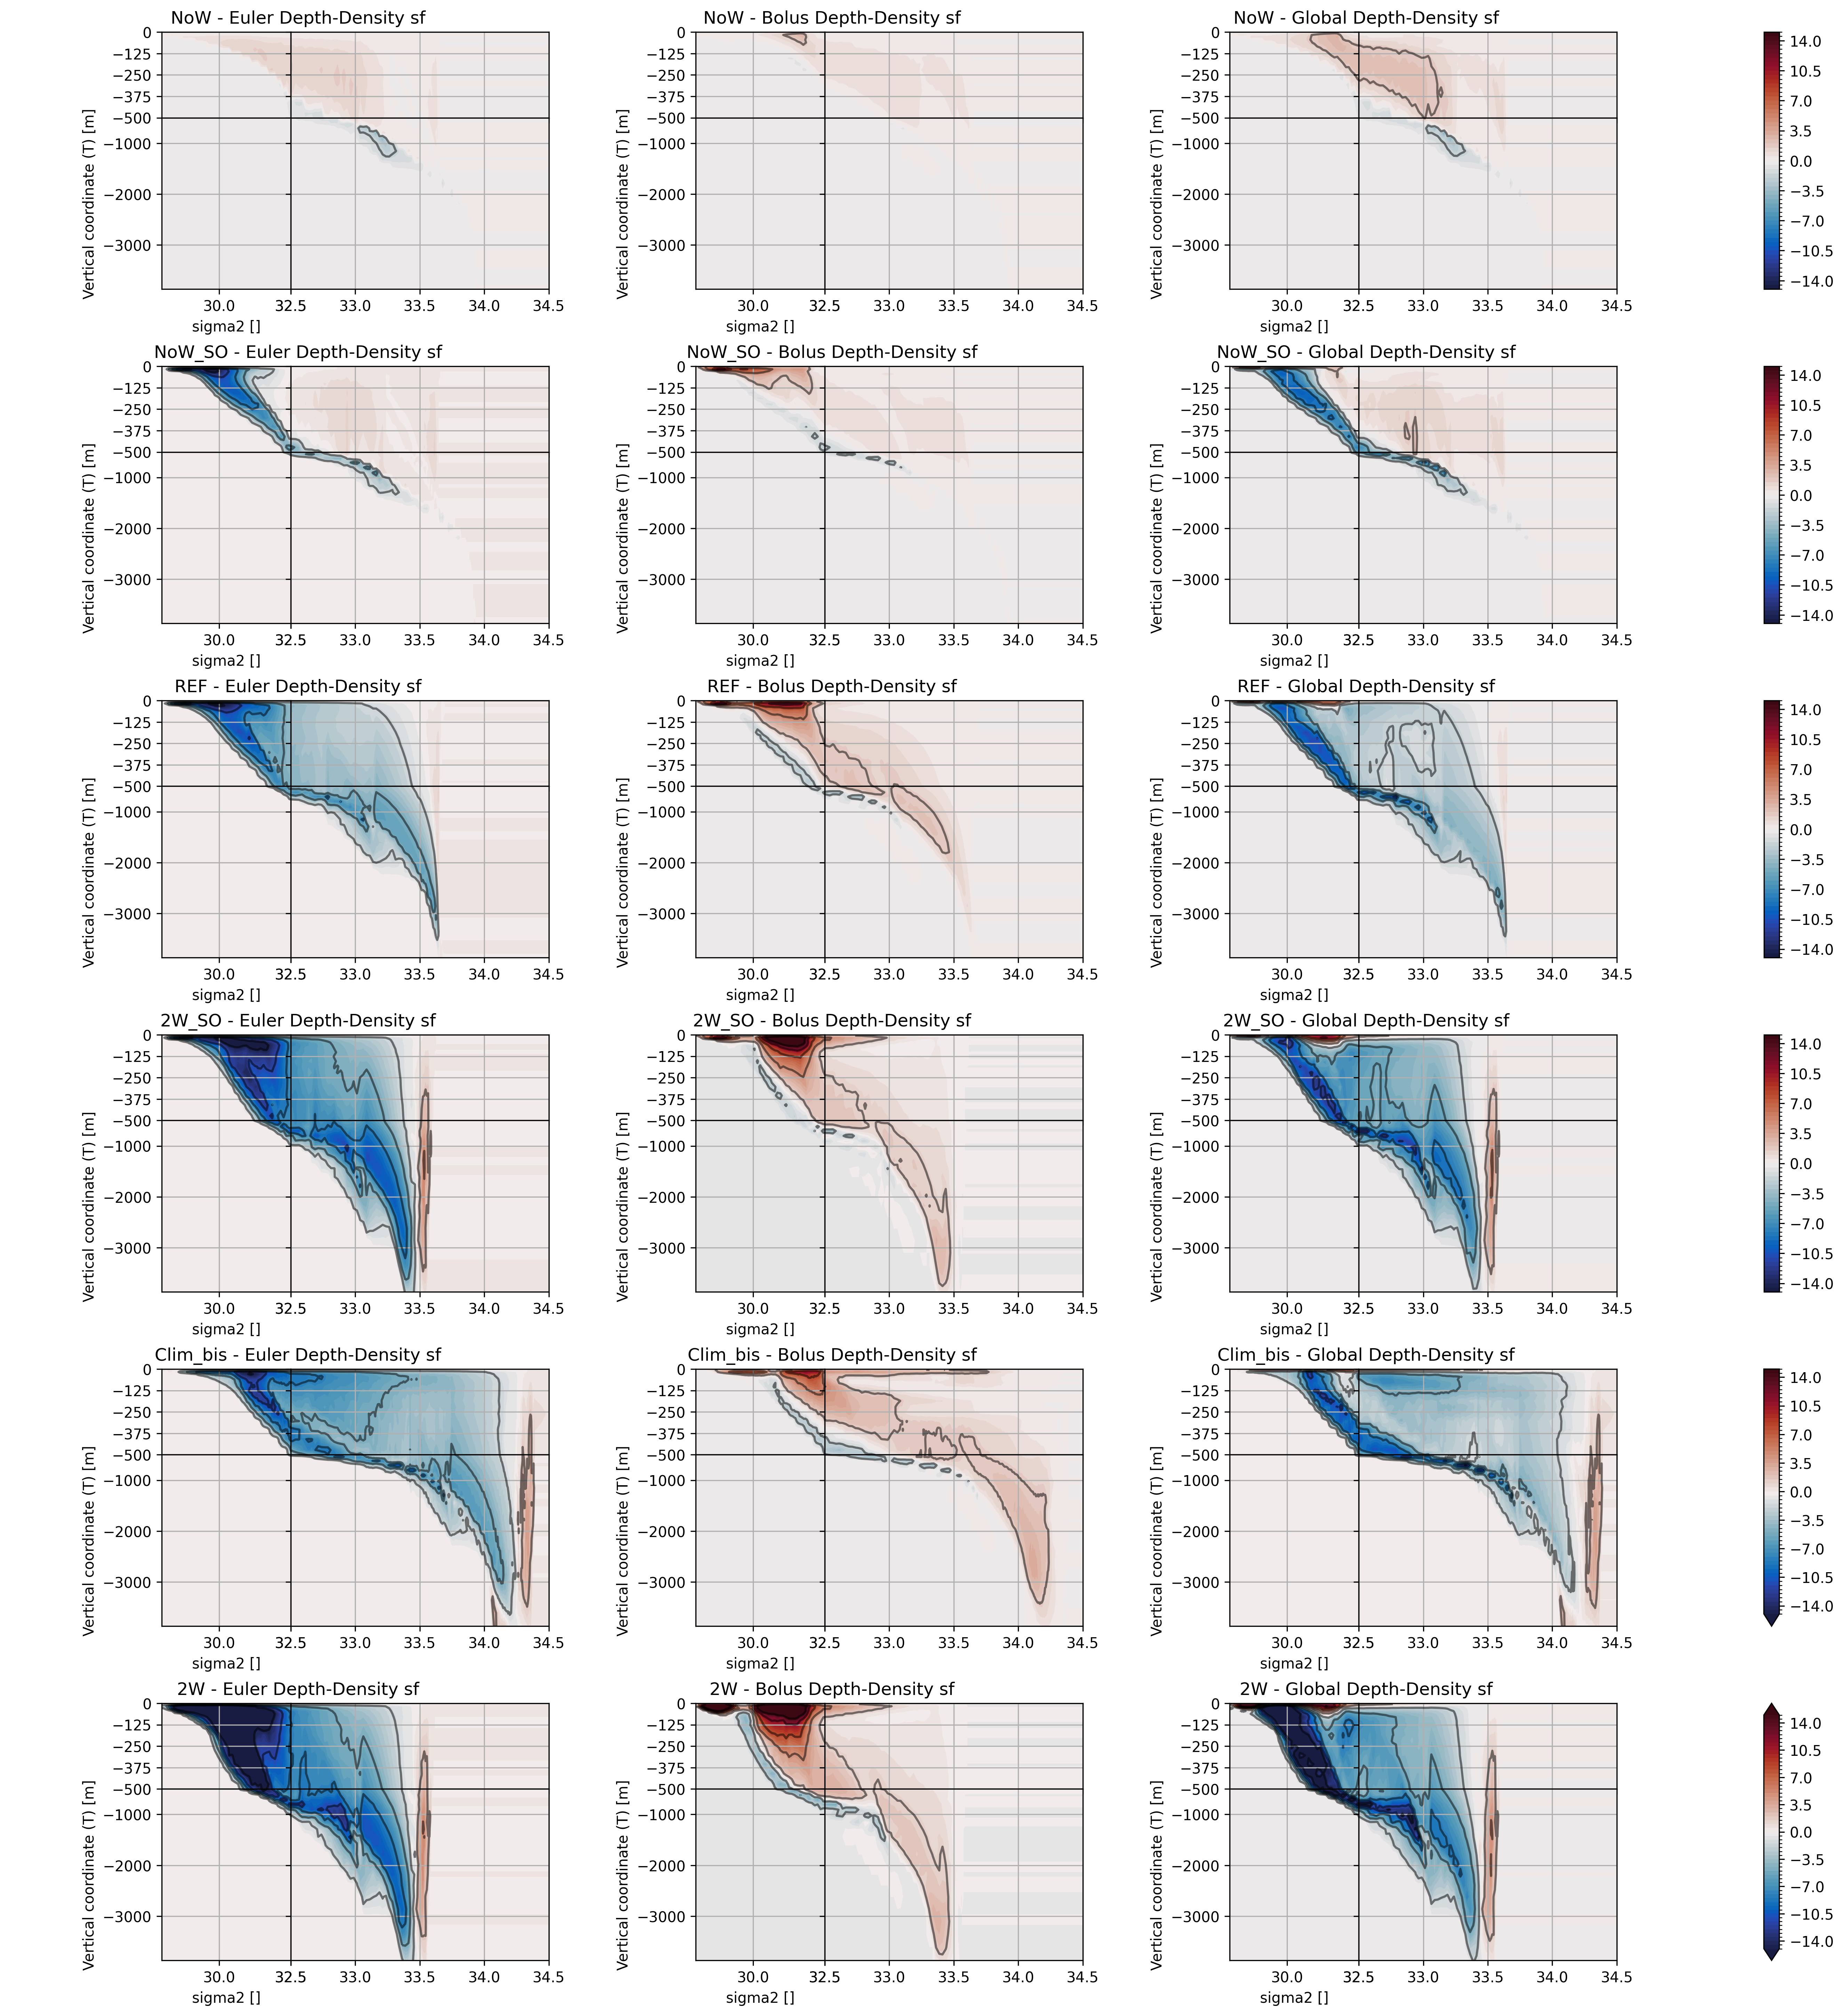

In [19]:
time_i=-1

fig = plt.figure(figsize=(20,24), dpi=300)
gs = gridspec.GridSpec(6, 1, figure=fig, hspace=0.3)


for idx, key in enumerate(keys_to_plot) :
    gs_line = gs[idx].subgridspec(1, 4, width_ratios=[1, 1, 1, 0.04],  wspace=0.5, hspace=0.3)
    sig_limits = (28, 32.5,34.5)

    dd_sf_eul = datasets_ovr[key].dd_sf_eul.isel(Time=time_i).cumsum('sigma2') * 1e-6
    cont_dd_sf_eul = plot_axis_i(fig, gs_line, 0, dd_sf_eul, title_i= key + ' - Euler Depth-Density sf', sig_lims=sig_limits)

    dd_sf_bolus = datasets_ovr[key].dd_sf_bolus.isel(Time=time_i).cumsum('sigma2') * 1e-6
    cont_dd_sf_bolus = plot_axis_i(fig, gs_line, 1, dd_sf_bolus, title_i= key + ' - Bolus Depth-Density sf', sig_lims=sig_limits)

    dd_sf_glob = dd_sf_eul + dd_sf_bolus
    cont_dd_sf_glob = plot_axis_i(fig, gs_line, 2, dd_sf_glob, title_i= key + ' - Global Depth-Density sf', sig_lims=sig_limits)

    cax = fig.add_subplot(gs_line[3]) 
    fig.colorbar(cont_dd_sf_glob, cax=cax, orientation='vertical')

In [25]:
## REF and others
Sp1 = np.hstack([np.arange(0, 28, 2),np.arange(28, 32.5, .1),np.arange(32.5, 33.5, .025),np.arange(33.5, 34, .01),35,40])
Sp2 = np.hstack([np.arange(0, 28, 2),np.arange(28, 32., .05),np.arange(32., 33.1, .025),np.arange(33.1, 34.1, .01), np.arange(34.1, 34.4, .005),35,40])
## Clim and others
#Sp1 = np.hstack([np.arange(0, 28, 2),np.arange(28, 32., .05),np.arange(32., 33.1, .025),np.arange(33.1, 34.1, .01), np.arange(34.1, 34.4, .005),35,40])

dSp1 = np.diff(Sp1)
dSp2 = np.diff(Sp2)

dZp1 = ds_snap.dzt.values[np.newaxis, :]
dSp1.shape
space = {"NoW": '   ', "NoW_SO": '', "REF": '   ', "Clim_bis": '',  "2W": '    ', "2W_SO": ' ', }

Conv_rate = {}
for key in keys_to_plot : 
    dS = dSp1
    if key =='Clim_bis':
        dS = dSp2

    dd_sf_eul = datasets_ovr[key].dd_sf_eul.isel(Time=time_i).cumsum('sigma2') * 1e-6
    dd_sf_bolus = datasets_ovr[key].dd_sf_bolus.isel(Time=time_i).cumsum('sigma2') * 1e-6
    dd_sf_glob = dd_sf_eul + dd_sf_bolus

    C_euler =  9.81 * np.sum(dd_sf_eul.transpose('sigma2', 'zt') * 1e6 * dS[:, np.newaxis] * dZp1)
    C_bolus =  9.81 * np.sum(dd_sf_bolus.transpose('sigma2', 'zt') * 1e6 * dS[:, np.newaxis] * dZp1)
    C_resid =  9.81 * np.sum(dd_sf_glob.transpose('sigma2', 'zt') * 1e6 * dS[:, np.newaxis] * dZp1)
    Conv_rate[key] = {"C_euler" : C_euler.values * 1e-9, "C_bolus" : C_bolus.values * 1e-9, "C_resid" : C_resid.values * 1e-9}

    print(key + space[key] + rf':   C_euler = {C_euler.values * 1e-9:.2e},    C_bolus = {C_bolus.values * 1e-9:.2e},    C_resid = {C_resid.values * 1e-9:.2e}')

NoW   :   C_euler = 4.72e+00,    C_bolus = 5.55e+00,    C_resid = 1.03e+01
NoW_SO:   C_euler = -5.06e+01,    C_bolus = 1.29e+01,    C_resid = -3.77e+01
REF   :   C_euler = -1.47e+02,    C_bolus = 3.52e+01,    C_resid = -1.12e+02
2W_SO :   C_euler = -2.48e+02,    C_bolus = 6.73e+01,    C_resid = -1.81e+02
Clim_bis:   C_euler = -1.49e+02,    C_bolus = 4.29e+01,    C_resid = -1.06e+02
2W    :   C_euler = -3.61e+02,    C_bolus = 9.67e+01,    C_resid = -2.65e+02


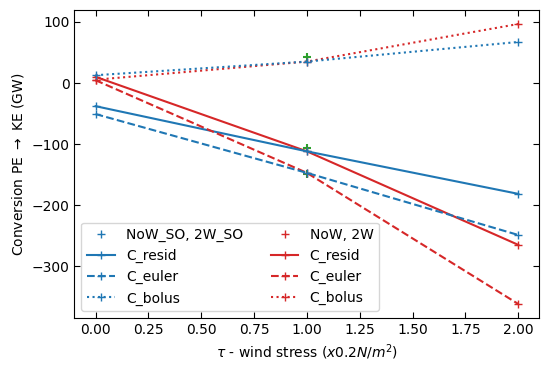

In [ ]:
key_Wind_SO = ["NoW_SO", "REF", "2W_SO"]
key_Wind = ["NoW", "REF", "2W"]

fig, ax = plt.subplots(1,1, figsize = (6,4))

ax.plot(np.array([tw[k] for k in key_Wind]), np.array([Conv_rate[k]["C_resid"] for k in key_Wind]), marker='+', color='tab:red', label = "C_resid")
ax.plot(np.array([tw[k] for k in key_Wind_SO]), np.array([Conv_rate[k]["C_resid"] for k in key_Wind_SO]), marker='+', color='tab:blue', label = "C_resid")

ax.plot(np.array([tw[k] for k in key_Wind]), np.array([Conv_rate[k]["C_euler"] for k in key_Wind]), marker='+', color='tab:red', linestyle='dashed', label = "C_euler")
ax.plot(np.array([tw[k] for k in key_Wind_SO]), np.array([Conv_rate[k]["C_euler"] for k in key_Wind_SO]), marker='+', color='tab:blue', linestyle='dashed', label = "C_euler")

ax.plot(np.array([tw[k] for k in key_Wind]), np.array([Conv_rate[k]["C_bolus"] for k in key_Wind]), marker='+', color='tab:red', linestyle='dotted', label = "C_bolus")
ax.plot(np.array([tw[k] for k in key_Wind_SO]), np.array([Conv_rate[k]["C_bolus"] for k in key_Wind_SO]), marker='+', color='tab:blue', linestyle='dotted', label = "C_bolus")


ax.scatter(np.array([1]), np.array([Conv_rate["Clim_bis"]["C_resid"]]), marker='+', color='tab:green', label = "C_resid")
ax.scatter(np.array([1]), np.array([Conv_rate["Clim_bis"]["C_euler"]]), marker='+', color='tab:green', label = "C_euler")
ax.scatter(np.array([1]), np.array([Conv_rate["Clim_bis"]["C_bolus"]]), marker='+', color='tab:green', label = "C_bolus")


lab_blue = Line2D([0], [0], marker='+', linestyle='None', color='tab:blue', markersize=6, label='NoW_SO, 2W_SO')
lab_red = Line2D([0], [0], marker='+', linestyle='None', color='tab:red', markersize=6, label='NoW, 2W')

handles, labels = ax.get_legend_handles_labels()
handles = [lab_blue, handles[1], handles[3], handles[5], lab_red, handles[0], handles[2], handles[4]]  # Adjust order if needed
labels = ["NoW_SO, 2W_SO", labels[1], labels[3], labels[5], "NoW, 2W", labels[0], labels[2], labels[4]]
ax.legend(handles, labels, ncols=2, frameon=True)

ax.set_xlabel(r'$\tau$ - wind stress $(x 0.2 N/m^2)$')
ax.set_ylabel(r'Conversion PE $\rightarrow$ KE (GW)')

ax.tick_params(axis="both", direction="in", length=4, right=True, top=True)